In [1]:
# Setup
import numpy as np
import math
import os

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.models as models

from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from scipy import linalg
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Global values

n_epochs = 50
batch_size = 128
lr_d = 0.0001
lr_g = 0.0002
beta1 = 0.5
beta2 = 0.999
latent_dim = 100
n_classes = 10

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

cpu


In [3]:
# Helper functions

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight, 1.0, 0.02)
        torch.nn.init.constant(m.bias, 0.0)


In [4]:
# Configure dataset

def data_setup(dataset):
  if dataset == 'MNIST':
    img_size = 28
    channels = 1
    train_dataset = datasets.MNIST('data',
                                  train=True,
                                  download=True,
                                  transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])
                                    ]))
  C = channels
  H, W = img_size, img_size

  train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
  print('Data loaded okay')
  print(f'Num batches: {len(train_loader)}')

  batch_idx, (images, targets) = next(enumerate(train_loader))

  plt.figure(figsize=(8,8))
  plt.axis("off")
  pictures = vutils.make_grid(images[torch.randint(len(images), (100,))],nrow=10,padding=2, normalize=True)
  plt.imshow(pictures.permute(1,2,0))
  plt.show()

  img_path = '../Conditional'

  if not os.path.exists(img_path):
    os.makedirs(img_path)
  save_image(pictures,fp='{}/epoch_{}-{}.png'.format(img_path, 0, 0))

  return train_loader, C, H, W

In [5]:
# Generator
class Generator(nn.Module):
    # initializers
    def __init__(self, dataset):
        super(Generator, self).__init__()
        self.fc_embeddings = nn.Embedding(n_classes, n_classes)
        self.dataset = dataset

        self.models = nn.ModuleDict({
             'MNIST': nn.Sequential(
                          nn.Linear(latent_dim + n_classes, 128),
                          nn.LeakyReLU(0.2, inplace=True),

                          nn.Linear(128, 256),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Dropout(0.3),

                          nn.Linear(256, 512),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Dropout(0.3),

                          nn.Linear(512, 1024),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Dropout(0.3),

                          nn.Linear(1024, 1 * 28 * 28),
                          nn.Tanh()
              )
        })

    # forward method
    def forward(self, input, cond):
      c = self.fc_embeddings(cond)
      x = torch.cat([input, c], 1)
      x = self.models[self.dataset](x)

      return x

In [6]:
# Discriminator

class Discriminator(nn.Module):
    # initializers
    def __init__(self, dataset):
        super(Discriminator, self).__init__()
        self.fc_embeddings = nn.Embedding(n_classes, n_classes)
        self.dataset = dataset

        self.models = nn.ModuleDict({
            'MNIST': nn.Sequential(
                          nn.Linear((1 * 28 * 28) + n_classes, 1024),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Dropout(0.3),

                          nn.Linear(1024, 512),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Dropout(0.3),

                          nn.Linear(512, 256),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Dropout(0.3),

                          nn.Linear(256, 1),
                          nn.Sigmoid()
            )
        })

    # forward method
    def forward(self, input, cond):
      c = self.fc_embeddings(cond)
      x = torch.cat([input, c], 1)
      x = self.models[self.dataset](x)

      return x

In [7]:
# Inception models for FID Score

def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`"""
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    # Skips default weight inititialization if supported by torchvision
    # version. See https://github.com/mseitzer/pytorch-fid/issues/28.
    if version >= (0, 6):
        kwargs['init_weights'] = False

    # Backwards compatibility: `weights` argument was handled by `pretrained`
    # argument prior to version 0.13.
    if version < (0, 13) and 'weights' in kwargs:
        if kwargs['weights'] == 'DEFAULT':
            kwargs['pretrained'] = True
        elif kwargs['weights'] is None:
            kwargs['pretrained'] = False
        else:
            raise ValueError(
                'weights=={} not supported in torchvision {}'.format(
                    kwargs['weights'], torchvision.__version__
                )
            )
        del kwargs['weights']

    return torchvision.models.inception_v3(*args, **kwargs)

In [8]:
# InceptionV3 Model for FID Score

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):

        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        # Using torchvision inception
        inception = _inception_v3(weights='DEFAULT')

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [9]:
# FID Calculation

def calculate_activation_statistics(images, model, batch_size=128, dims=2048, device='cpu'):
    model.eval()
    act=np.empty((len(images), dims))

    batch = images.to(device)
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2


    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))


    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


def calc_fid(real, fake, batch_size, C, H, W):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx])
    model = model.to(device)
    fake = torch.reshape(fake, (batch_size, C, H, W))
    real = torch.reshape(real, (batch_size, C, H, W))

    if C != 3:
      fake = fake.repeat(1, 3, 1, 1)
      real = real.repeat(1, 3, 1, 1)

    assert(real.size() == fake.size())

    mu_1, std_1 = calculate_activation_statistics(real, model, batch_size=batch_size, device=device)
    mu_2, std_2 = calculate_activation_statistics(fake, model, batch_size=batch_size, device=device)

    fid_val = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_val

In [10]:
def train(dataset, img_path):

  # Training setup + Dataloader
  train_loader, C, H, W = data_setup(dataset)

  # Loss function
  criterion = torch.nn.BCELoss()

  # Initialize Generator and discriminator
  generator = Generator(dataset)
  discriminator = Discriminator(dataset)

  # Initialize weights
  #generator.apply(weights_init_normal)
  #discriminator.apply(weights_init_normal)

  generator.to(device)
  discriminator.to(device)
  criterion.to(device)

  # Optimizers
  optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

  print("Generator Parameters:",sum(p.numel() for p in generator.parameters() if p.requires_grad))
  print("Discriminator Parameters:",sum(p.numel() for p in discriminator.parameters() if p.requires_grad))


  g_losses_total = []
  d_losses_total = []

  g_losses_epoch = []
  d_losses_epoch = []

  real_ind = 0.9
  fake_ind = 0.1
  iters = 0


  for epoch in range(n_epochs):

      for i, data in enumerate(train_loader):

          batch_size = data[0].size(0)
          real_imgs = data[0].view(batch_size, C * H * W).to(device)

          # condition labels
          real_target_labels = data[1].to(device)
          fake_target_labels = torch.randint(0, 10, (batch_size,)).to(device)

          # Real/Fake scores
          real_score = torch.full((batch_size,), real_ind, device=device)
          fake_score = torch.full((batch_size,), fake_ind, device=device)


          # ---------------------
          #  Train Discriminator
          # ---------------------
          optimizer_D.zero_grad()

          # Forward pass for real images

          # add noise to discriminator input
          #real_imgs = 0.9*real_imgs + 0.1*torch.randn((real_imgs.size()), device=device)
          real_imgs = real_imgs
          real_loss = discriminator(real_imgs, real_target_labels).view(batch_size)
          d_real_loss = criterion(real_loss, real_score)


          # Forward pass for fake images
          noise = torch.randn(batch_size, latent_dim, device=device)
          gen_imgs = generator(noise, fake_target_labels)
          fake_loss = discriminator(gen_imgs.detach(), fake_target_labels).view(batch_size)
          d_fake_loss = criterion(fake_loss, fake_score)

          # Total discriminator loss
          d_loss = d_real_loss + d_fake_loss

          # Calculate gradients
          d_loss.backward()

          # Update D
          optimizer_D.step()


          # -----------------
          #  Train Generator (fool Discriminator)
          # -----------------
          optimizer_G.zero_grad()

          # Add noise to discriminator
          #gen_imgs = 0.9*gen_imgs + 0.1*torch.randn((gen_imgs.size()), device=device)
          gen_imgs = gen_imgs
          output = discriminator(gen_imgs, fake_target_labels)

          g_loss = criterion(output.squeeze(), real_score)

          g_loss.backward()
          optimizer_G.step()


          d_losses_total.append(d_loss.item())
          g_losses_total.append(g_loss.item())
          iters += 1


      # Each Epoch
      d_losses_epoch.append(d_loss.item())
      g_losses_epoch.append(g_loss.item())
      fid = calc_fid(real_imgs, gen_imgs, batch_size, C, H, W)

      print ("[Epoch %d/%d] \t[Batch %d/%d] \tF[D loss: %.4f] \tF[G loss: %.4f] \tFID: %.4f" % (epoch, n_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item(), fid))


      # Every 5 epochs generate sample image
      if (epoch % 5 == 0):
        print(f"Epochs completed: {epoch}\t Iterations completed: {iters}")

        with torch.no_grad():
          noise = torch.randn(batch_size, latent_dim, device=device)
          fake_target_labels = torch.randint(0, 10, (batch_size,)).to(device)
          gen_imgs = generator(noise, fake_target_labels).cpu().view(batch_size, C, H, W)

          plt.figure(figsize=(8,8))
          plt.axis("off")
          pictures = vutils.make_grid(gen_imgs[torch.randint(len(gen_imgs), (100,))],nrow=10,padding=2, normalize=True)
          plt.imshow(pictures.permute(1,2,0))
          if not os.path.exists(img_path):
            os.makedirs(img_path)
          save_image(pictures,fp='{}/epoch_{}-{}.png'.format(img_path, epoch, n_epochs))


          plt.show()

  return d_losses_total, g_losses_total, d_losses_epoch, g_losses_epoch


In [11]:
# Plot loss
def plot_total(d_losses_total, g_losses_total):
  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training (total)")
  plt.plot(g_losses_total,label="G")
  plt.plot(d_losses_total,label="D")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_epoch(d_losses_epoch, g_losses_epoch):
  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training (epoch)")
  plt.plot(g_losses_epoch,label="G")
  plt.plot(d_losses_epoch,label="D")

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 100697571.54it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63388641.46it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31491265.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4950761.11it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Data loaded okay
Num batches: 469


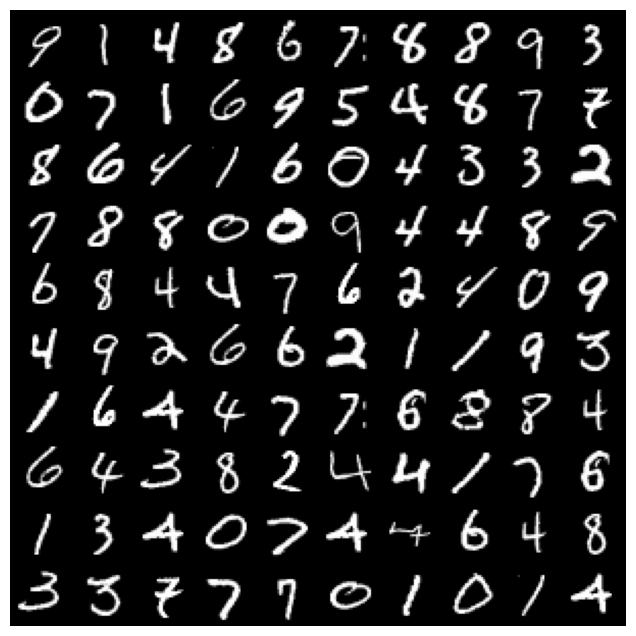

Generator Parameters: 1507828
Discriminator Parameters: 1470565


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:12<00:00, 9.08MB/s]


[Epoch 0/50] 	[Batch 469/469] 	F[D loss: 0.8208] 	F[G loss: 2.1156] 	FID: 309.3681
Epochs completed: 0	 Iterations completed: 469


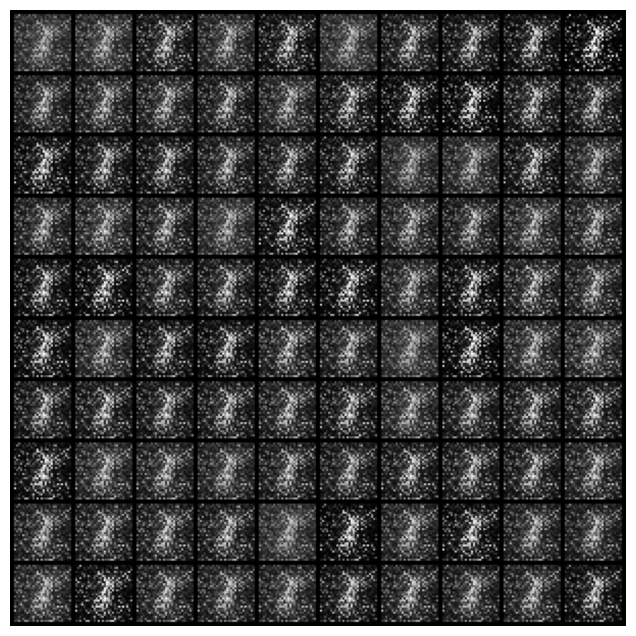

KeyboardInterrupt: ignored

In [12]:
# Training MNIST

dataset = 'MNIST'

img_path = '../Conditional'

d_losses_total_mnist, g_losses_total_mnist, d_losses_epoch_mnist, g_losses_epoch_mnist = train(dataset, img_path)

plot_total(d_losses_total_mnist, g_losses_total_mnist)
plot_epoch(d_losses_epoch_mnist, g_losses_epoch_mnist)